In [51]:
import os
import json
import math 
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

DATASET_PATH = "/work/home/maben/project/blue_whale_lab/projects/pareto_ebm/datasets"
CHECKPOINT_PATH = "/work/home/maben/project/blue_whale_lab/projects/pareto_ebm/notebooks/checkpoints"

pl.seed_everything(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/tmp/ipykernel_24958/2128991026.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Device: cuda:0


In [52]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(0.5,0.5)])

train_dataset = MNIST(root = DATASET_PATH, train = True, transform = transform, download = True)
test_dataset = MNIST(root = DATASET_PATH, train = False, transform = transform, download = True)

train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 4, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False, num_workers = 4, pin_memory = True)

In [53]:
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)

class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2

        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4), # [16x16] - Larger padding to get 32x32 image
                Swish(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                Swish(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                Swish(),
                nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [2x2]
                Swish(),
                nn.Flatten(),
                nn.Linear(c_hid3*4, c_hid3),
                Swish(),
                nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

In [54]:
class Sampler:
    # sampler of presistent CD
    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """
        Inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        Function for getting a new batch of "fake" images.
        Inputs:
            steps - Number of iterations in the MCMC algorithm
            step_size - Learning rate nu in the algorithm above
        """
        # Choose 95% of the batch from the buffer, 0% generate from scratch
        n_new = np.random.binomial(self.sample_size, 0)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)

        # Perform MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0))
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model.
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input.
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True

        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)

        # List for storing generations at each step (for later analysis)
        imgs_per_step = []

        # Loop over K (steps)
        for _ in range(steps):
            # Part 1: Add noise to the input.
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            # Part 2: calculate gradients for the current input.
            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients

            # Apply gradients to our current samples
            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())

        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)

        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

In [55]:
class DeepEnergyModel(pl.LightningModule):

    def __init__(self, img_shape, batch_size, alpha=0.1, lr=1e-4, beta1=0.0, **CNN_args):
        super().__init__()
        self.save_hyperparameters()

        self.cnn = CNNModel(**CNN_args)
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size)
        self.example_input_array = torch.zeros(1, *img_shape)

    def forward(self, x):
        z = self.cnn(x)
        return z

    def configure_optimizers(self):
        # Energy models can have issues with momentum as the loss surfaces changes with its parameters.
        # Hence, we set it to 0 by default.
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97) # Exponential decay over epochs
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # We add minimal noise to the original images to prevent the model from focusing on purely "clean" inputs
        real_imgs, _ = batch
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)

        # Obtain samples
        fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)

        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        # Calculate losses
        reg_loss = self.hparams.alpha * (real_out ** 2 + fake_out ** 2).mean()
        cdiv_loss = fake_out.mean() - real_out.mean()
        loss = reg_loss + cdiv_loss

        # Logging
        self.log('loss', loss)
        self.log('loss_regularization', reg_loss)
        self.log('loss_contrastive_divergence', cdiv_loss)
        self.log('metrics_avg_real', real_out.mean())
        self.log('metrics_avg_fake', fake_out.mean())
        return loss

    def validation_step(self, batch, batch_idx):
        # For validating, we calculate the contrastive divergence between purely random images and unseen examples
        # Note that the validation/test step of energy-based models depends on what we are interested in the model
        real_imgs, _ = batch
        fake_imgs = torch.rand_like(real_imgs) * 2 - 1

        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        cdiv = fake_out.mean() - real_out.mean()
        self.log('val_contrastive_divergence', cdiv)
        self.log('val_fake_out', fake_out.mean())
        self.log('val_real_out', real_out.mean())

In [56]:
class DeepEnergyModel(pl.LightningModule):

    def __init__(self, img_shape, batch_size, alpha=0.1, lr=1e-4, beta1=0.0, **CNN_args):
        super().__init__()
        self.save_hyperparameters()

        self.cnn = CNNModel(**CNN_args)
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size)
        self.example_input_array = torch.zeros(1, *img_shape)

    def forward(self, x):
        z = self.cnn(x)
        return z

    def configure_optimizers(self):
        # Energy models can have issues with momentum as the loss surfaces changes with its parameters.
        # Hence, we set it to 0 by default.
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97) # Exponential decay over epochs
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # We add minimal noise to the original images to prevent the model from focusing on purely "clean" inputs
        real_imgs, _ = batch
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)

        # Obtain samples
        #fake_imgs = self.sampler.generate_samples(self.cnn, real_imgs,steps=60, step_size=10)
        fake_imgs = self.sampler.generate_samples(self.cnn, real_imgs,steps=1, step_size=10)
        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        # Calculate losses
        reg_loss = self.hparams.alpha * (real_out ** 2 + fake_out ** 2).mean()
        cdiv_loss = fake_out.mean() - real_out.mean()
        loss = reg_loss + cdiv_loss

        # Logging
        self.log('loss', loss)
        self.log('loss_regularization', reg_loss)
        self.log('loss_contrastive_divergence', cdiv_loss)
        self.log('metrics_avg_real', real_out.mean())
        self.log('metrics_avg_fake', fake_out.mean())
        return loss

    def validation_step(self, batch, batch_idx):
        # For validating, we calculate the contrastive divergence between purely random images and unseen examples
        # Note that the validation/test step of energy-based models depends on what we are interested in the model
        real_imgs, _ = batch
        fake_imgs = torch.rand_like(real_imgs) * 2 - 1

        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        cdiv = fake_out.mean() - real_out.mean()
        self.log('val_contrastive_divergence', cdiv)
        self.log('val_fake_out', fake_out.mean())
        self.log('val_real_out', real_out.mean())

In [57]:
class GenerateCallback(pl.Callback):

    def __init__(self, batch_size=8, vis_steps=8, num_steps=256, every_n_epochs=5):
        super().__init__()
        self.batch_size = batch_size         # Number of images to generate
        self.vis_steps = vis_steps           # Number of steps within generation to visualize
        self.num_steps = num_steps           # Number of steps to take during generation
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_train_epoch_end(self, trainer, pl_module):
        # Skip for all other epochs
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Generate images
            imgs_per_step = self.generate_imgs(pl_module)
            # Plot and add to tensorboard
            for i in range(imgs_per_step.shape[1]):
                step_size = self.num_steps // self.vis_steps
                imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
                grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True)
                trainer.logger.experiment.add_image(f"generation_{i}", grid, global_step=trainer.current_epoch)

    def generate_imgs(self, pl_module):
        pl_module.eval()
        start_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
        start_imgs = start_imgs * 2 - 1
        torch.set_grad_enabled(True)  # Tracking gradients for sampling necessary
        imgs_per_step = Sampler.generate_samples(pl_module.cnn, start_imgs, steps=self.num_steps, step_size=10, return_img_per_step=True)
        torch.set_grad_enabled(False)
        pl_module.train()
        return imgs_per_step

In [58]:
class SamplerCallback(pl.Callback):

    def __init__(self, num_imgs=32, every_n_epochs=5):
        super().__init__()
        self.num_imgs = num_imgs             # Number of images to plot
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            exmp_imgs = torch.cat(random.choices(pl_module.sampler.examples, k=self.num_imgs), dim=0)
            grid = torchvision.utils.make_grid(exmp_imgs, nrow=4, normalize=True)
            trainer.logger.experiment.add_image("sampler", grid, global_step=trainer.current_epoch)

In [59]:
class OutlierCallback(pl.Callback):

    def __init__(self, batch_size=1024):
        super().__init__()
        self.batch_size = batch_size

    def on_train_epoch_end(self, trainer, pl_module):
        with torch.no_grad():
            pl_module.eval()
            rand_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
            rand_imgs = rand_imgs * 2 - 1.0
            rand_out = pl_module.cnn(rand_imgs).mean()
            pl_module.train()

        trainer.logger.experiment.add_scalar("rand_out", rand_out, global_step=trainer.current_epoch)

In [60]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "MNIST"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=60,
                         gradient_clip_val=0.1,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor='val_contrastive_divergence'),
                                    GenerateCallback(every_n_epochs=5),
                                    SamplerCallback(every_n_epochs=5),
                                    OutlierCallback(),
                                    LearningRateMonitor("epoch")
                                   ])
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "MNIST.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = DeepEnergyModel(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = DeepEnergyModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # No testing as we are more interested in other properties
    return model

In [61]:
model = train_model(img_shape=(1,28,28),
                    batch_size=train_loader.batch_size,
                    devices=4,
                    lr=1e-4,
                    beta1=0.0)

/work/home/maben/software/anaconda3/envs/diffusion/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /work/home/maben/software/anaconda3/envs/diffusion/l ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type     | Params | Mode  | In sizes       | Out sizes
-----------------------------------------------------------------------
0 | cnn  | CNNModel | 77.0 K | train | [1, 1, 28, 28] | [1]      
-----------------------------------------------------------------------
77.0 K    Trainable params
0         Non-trainable params
77.0 K    Total params
0.308     Total estimated model params size (MB)
14        Modules in train mode
0         Modu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


In [62]:
model.to(device)
pl.seed_everything(43)
callback = GenerateCallback(batch_size=4, vis_steps=8, num_steps=256)
imgs_per_step = callback.generate_imgs(model)
imgs_per_step = imgs_per_step.cpu()

Seed set to 43


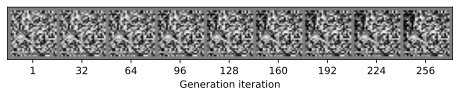

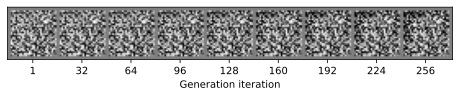

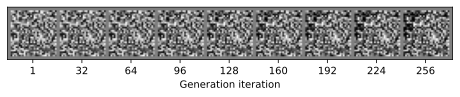

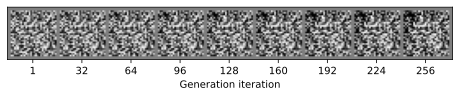

In [63]:
for i in range(imgs_per_step.shape[1]):
    step_size = callback.num_steps // callback.vis_steps
    imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
    imgs_to_plot = torch.cat([imgs_per_step[0:1,i],imgs_to_plot], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8,8))
    plt.imshow(grid)
    plt.xlabel("Generation iteration")
    plt.xticks([(imgs_per_step.shape[-1]+2)*(0.5+j) for j in range(callback.vis_steps+1)],
               labels=[1] + list(range(step_size,imgs_per_step.shape[0]+1,step_size)))
    plt.yticks([])
    plt.show()

In [64]:
with torch.no_grad():
    rand_imgs = torch.rand((128,) + model.hparams.img_shape).to(model.device)
    rand_imgs = rand_imgs * 2 - 1.0
    rand_out = model.cnn(rand_imgs).mean()
    print(f"Average score for random images: {rand_out.item():4.2f}")

Average score for random images: -0.06


In [65]:
with torch.no_grad():
    train_imgs,_ = next(iter(train_loader))
    train_imgs = train_imgs.to(model.device)
    train_out = model.cnn(train_imgs).mean()
    print(f"Average score for training images: {train_out.item():4.2f}")

Average score for training images: -0.00


In [66]:
@torch.no_grad()
def compare_images(img1, img2):
    imgs = torch.stack([img1, img2], dim=0).to(model.device)
    score1, score2 = model.cnn(imgs).cpu().chunk(2, dim=0)
    grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,4))
    plt.imshow(grid)
    plt.xticks([(img1.shape[2]+2)*(0.5+j) for j in range(2)],
               labels=["Original image", "Transformed image"])
    plt.yticks([])
    plt.show()
    print(f"Score original image: {score1.item():4.2f}")
    print(f"Score transformed image: {score2.item():4.2f}")

In [67]:
test_imgs, _ = next(iter(test_loader))
exmp_img = test_imgs[0].to(model.device)

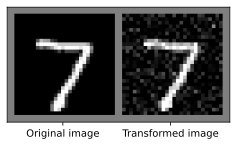

Score original image: 0.00
Score transformed image: -0.01


In [68]:
img_noisy = exmp_img + torch.randn_like(exmp_img) * 0.3
img_noisy.clamp_(min=-1.0, max=1.0)
compare_images(exmp_img, img_noisy)

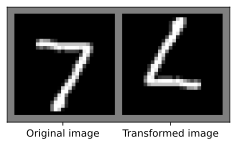

Score original image: 0.00
Score transformed image: -0.00


In [69]:
img_flipped = exmp_img.flip(dims=(1,2))
compare_images(exmp_img, img_flipped)

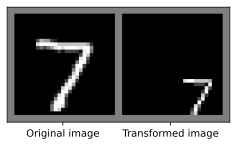

Score original image: 0.00
Score transformed image: 0.00


In [70]:
img_tiny = torch.zeros_like(exmp_img)-1
img_tiny[:,exmp_img.shape[1]//2:,exmp_img.shape[2]//2:] = exmp_img[:,::2,::2]
compare_images(exmp_img, img_tiny)